# A. select features

In [1]:
import csv, sys, math, copy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset_type = 'imdb-1m'
dataset_base_path = f'../../preparation/imdb/{dataset_type}'
dataset_movies_path = f'{dataset_base_path}/movies.csv'
dataset_interactions_path = f'{dataset_base_path}/interactions.csv'
dataset_interaction_counts_path = f'{dataset_base_path}/interaction-counts.csv'
dataset_selected_features_path = f'{dataset_type}/selected-features.csv'

In [3]:
if dataset_type == 'imdb-25m':
    csv.field_size_limit(sys.maxsize)

## 1. get movies.csv data

In [4]:
with open(dataset_movies_path, 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    headers = next(csv_reader)
    movies = [row for row in csv_reader]

print(headers)

['imdbId', 'type', 'name', 'ratingCount', 'bestRating', 'worstRating', 'ratingValue', 'contentRating', 'genre', 'datePublished', 'keywords', 'actor', 'director', 'creator', 'duration', 'popularity', 'userReviews', 'criticReviews', 'metaScore']


## 2. selected features
- imdbId
- type
- ratingCount
- ratingValue
- genre
- userReviews
- criticReviews

In [5]:
imdbId_index = headers.index('imdbId')
type_index = headers.index('type')
ratingCount_index = headers.index('ratingCount')
ratingValue_index = headers.index('ratingValue')
genre_index = headers.index('genre')
userReviews_index = headers.index('userReviews')
criticReviews_index = headers.index('criticReviews')

In [6]:
movie_types, genres = [], []

for movie in movies:
    # movie types
    if (movie_type := movie[type_index]) and (movie_type not in movie_types):
        movie_types.append(movie_type)

    # genres
    if genre := movie[genre_index]:
        for genre in genre.split(','):
            (genre not in genres) and genres.append(genre)

print(f'movie types:\n{movie_types}\n')
print(f'genres:\n{genres}\n')

movie types:
['Movie', 'TVSeries', 'TVEpisode']

genres:
['Short', 'Comedy', 'Drama', 'Adventure', 'Western', 'Romance', 'Family', 'Fantasy', 'Horror', 'History', 'Thriller', 'Sport', 'Crime', 'Mystery', 'Sci-Fi', 'Action', 'War', 'Animation', 'Musical', 'Documentary', 'Music', 'Biography', 'Film-Noir', 'News']


## 3. clean and scale features

In [7]:
def get_type_vector(_type):
    type_vector = [0] * len(movie_types)

    if _type in movie_types:
        type_vector[movie_types.index(_type)] = 1

    return type_vector


def get_genre_vector(_genres):
    genre_vector = [0] * len(genres)

    if _genres is None:
        return genre_vector

    for _genre in _genres.split(','):
        if _genre in genres:
            genre_vector[genres.index(_genre)] = 1

    return genre_vector

In [8]:
new_headers = ['imdbId']
new_headers.extend(list(map(lambda key: f'type{key}', movie_types)))
new_headers.extend(['ratingCount', 'ratingValue'])
new_headers.extend(list(map(lambda key: f'genre{key}', genres)))
new_headers.extend(['userReviews', 'criticReviews'])

In [9]:
new_imdbId_index = new_headers.index('imdbId')
new_ratingCount_index = new_headers.index('ratingCount')
new_ratingValue_index = new_headers.index('ratingValue')
new_userReviews_index = new_headers.index('userReviews')
new_criticReviews_index = new_headers.index('criticReviews')

In [10]:
new_rows = [new_headers]

for movie in movies:
    imdbId = movie[imdbId_index]

    type_vector = get_type_vector(movie[type_index])

    ratingCount = movie[ratingCount_index]
    if ratingCount == '': ratingCount = 0

    ratingValue = movie[ratingValue_index]
    if ratingValue == '': ratingValue = 0

    genre_vector = get_genre_vector(movie[genre_index])

    userReviews = movie[userReviews_index]
    if userReviews == '':
        userReviews = 0
    elif 'k' in userReviews.lower():
        userReviews = float(userReviews[:-1]) * 1000

    criticReviews = movie[criticReviews_index]
    if criticReviews == '':
        criticReviews = 0
    elif 'k' in criticReviews.lower():
        criticReviews = float(criticReviews[:-1]) * 1000

    new_row = [imdbId]
    new_row.extend(type_vector)
    new_row.append(int(ratingCount))
    new_row.append(float(ratingValue))
    new_row.extend(genre_vector)
    new_row.append(int(userReviews))
    new_row.append(int(criticReviews))

    new_rows.append(new_row)

In [11]:
def get_boundary(values):
    coefficient = 0.999 if dataset_type == 'imdb-25m' else 0.99
    index = round(coefficient * len(values)) - 1
    return values[index]


def scale_1(value):
    return round(math.tan((math.pi / 30) * value), 5)


def scale_2(value, boundary):
    return round(math.tanh(value / boundary), 5)

In [12]:
ratingCount_boundary = get_boundary(sorted([new_row[new_ratingCount_index] for new_row in new_rows[1:]]))
userReviews_boundary = get_boundary(sorted([new_row[new_userReviews_index] for new_row in new_rows[1:]]))
criticReviews_boundary = get_boundary(sorted([new_row[new_criticReviews_index] for new_row in new_rows[1:]]))

new_rows_unscaled = copy.deepcopy(new_rows)

for new_row in new_rows[1:]:
    new_row[new_ratingValue_index] = round(scale_1(new_row[new_ratingValue_index]) / scale_1(10), 5)  # ratingValue
    new_row[new_ratingCount_index] = scale_2(new_row[new_ratingCount_index], ratingCount_boundary)  # ratingCount
    new_row[new_userReviews_index] = scale_2(new_row[new_userReviews_index], userReviews_boundary)  # userReviews
    new_row[new_criticReviews_index] = scale_2(new_row[new_criticReviews_index], criticReviews_boundary)  # criticReviews

In [13]:
with open(dataset_selected_features_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(new_rows)

## 4. visualize scaling

In [14]:
ratingCount_scaling, ratingValue_scaling, userReviews_scaling, criticReviews_scaling = [], [], [], []

for new_row_unscaled, new_row in zip(new_rows_unscaled[1:], new_rows[1:]):
    ratingCount_scaling.append([new_row_unscaled[new_ratingCount_index], new_row[new_ratingCount_index]])
    ratingValue_scaling.append([new_row_unscaled[new_ratingValue_index], new_row[new_ratingValue_index]])
    userReviews_scaling.append([new_row_unscaled[new_userReviews_index], new_row[new_userReviews_index]])
    criticReviews_scaling.append([new_row_unscaled[new_criticReviews_index], new_row[new_criticReviews_index]])

ratingCount_scaling.sort(key=lambda x: x[0])
ratingValue_scaling.sort(key=lambda x: x[0])
userReviews_scaling.sort(key=lambda x: x[0])
criticReviews_scaling.sort(key=lambda x: x[0])

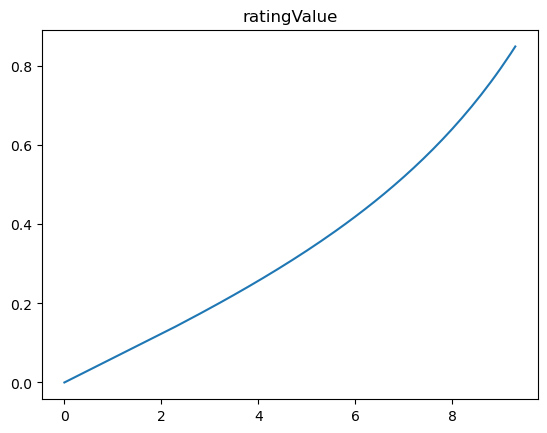

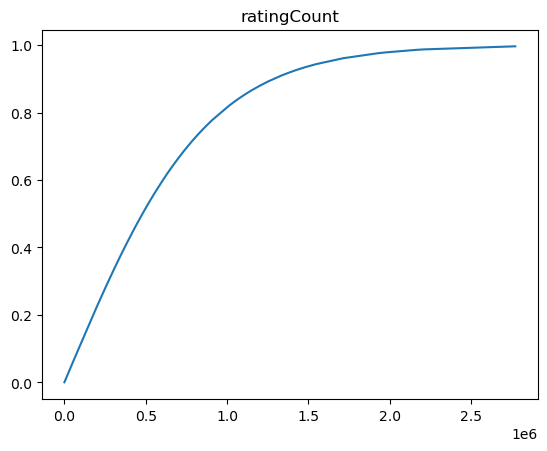

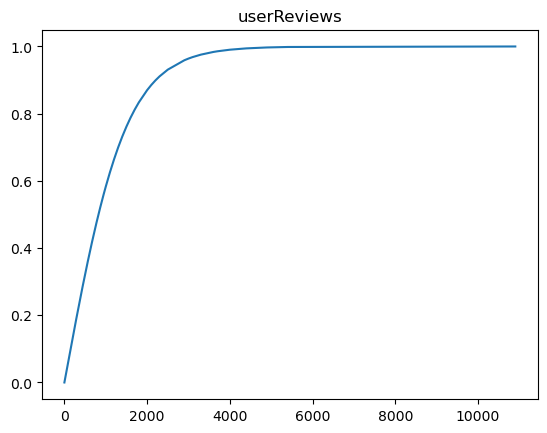

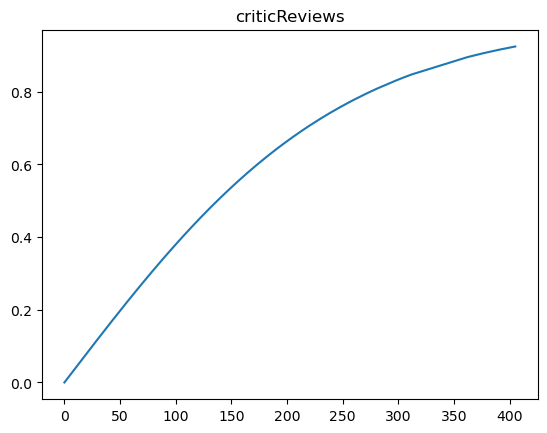

In [15]:
# ratingValue
X = np.array([point[0] for point in ratingValue_scaling])
Y = np.array([point[1] for point in ratingValue_scaling])
plt.title('ratingValue')
plt.plot(X, Y)
plt.show()

# ratingCount
X = np.array([point[0] for point in ratingCount_scaling])
Y = np.array([point[1] for point in ratingCount_scaling])
plt.title('ratingCount')
plt.plot(X, Y)
plt.show()

# userReviews
X = np.array([point[0] for point in userReviews_scaling])
Y = np.array([point[1] for point in userReviews_scaling])
plt.title('userReviews')
plt.plot(X, Y)
plt.show()

# criticReviews
X = np.array([point[0] for point in criticReviews_scaling])
Y = np.array([point[1] for point in criticReviews_scaling])
plt.title('criticReviews')
plt.plot(X, Y)
plt.show()

# B. create matrices

## 1. interactions

In [16]:
with open(dataset_interactions_path, 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)
    ui_interactions = [row for row in csv_reader]  # user-item interactions

In [17]:
with open(dataset_interaction_counts_path, 'r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)
    ui_interaction_counts = [[row[0], int(row[1])] for row in csv_reader]  # user-item interaction counts

interaction_counts_unscaled = copy.deepcopy(ui_interaction_counts)

interaction_counts_boundary = get_boundary(sorted([int(row[1]) for row in ui_interaction_counts]))
for interaction_count in ui_interaction_counts:
    interaction_count[1] = scale_2(int(interaction_count[1]), interaction_counts_boundary)

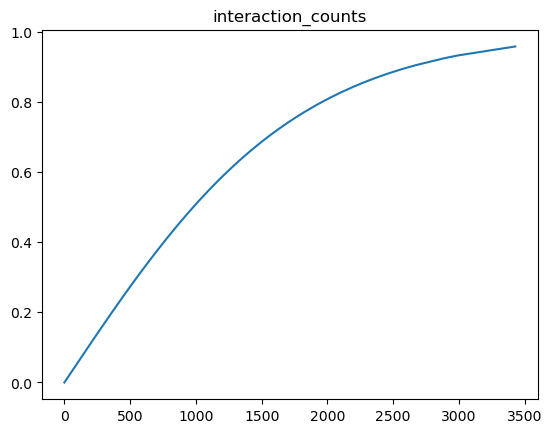

In [18]:
interaction_counts_scaling = []

for interaction_count_unscaled, interaction_count in zip(interaction_counts_unscaled, ui_interaction_counts):
    interaction_counts_scaling.append([interaction_count_unscaled[1], interaction_count[1]])

interaction_counts_scaling.sort(key=lambda x: x[0])

# interaction_counts
X = np.array([point[0] for point in interaction_counts_scaling])
Y = np.array([point[1] for point in interaction_counts_scaling])
plt.title('interaction_counts')
plt.plot(X, Y)
plt.show()

## 2. matrices
- item_names
- item_interactions
- item_interactions_diff
- item_features
- ii_weights
- user_names
- ui_weights

In [19]:
num_items = len(ui_interaction_counts)
num_users = len(ui_interactions)
num_item_features = len(new_headers) - 1 # the -1 is for ignoring the imdbId

In [21]:
# once this code executed, the results will be available in 'matrices' directory
# keep in mind that the order of data in these matrices is important

matrices_base_path = f'{dataset_type}/matrices'

# item_names
item_names = [[f"item_{row[0]}"] for row in new_rows[1:]]
with open(f'{matrices_base_path}/item_names.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(item_names)

# item_interactions
item_interactions = np.memmap(
    f'{matrices_base_path}/item_interactions.dat',
    dtype=np.float32, mode='w+', shape=(num_items, 1)
)

for i in range(num_items):
    item_interactions[i] = ui_interaction_counts[i][1]

# item_interactions_diff
item_interactions_diff = np.memmap(
    f'{matrices_base_path}/item_interactions_diff.dat',
    dtype=np.float32, mode='w+', shape=(num_items, num_items)
)

for i in range(num_items):
    diff = abs(item_interactions - item_interactions[i])
    item_interactions_diff[i, :] = np.reshape(diff, (diff.shape[0],))

# item_features
item_features = np.memmap(
    f'{matrices_base_path}/item_features.dat',
    dtype=np.float32, mode='w+', shape=(num_items, num_item_features)
)

for i in range(num_items):
    item_features[i, :] = new_rows[i + 1][1:]

# item-item weights
ii_weights = np.memmap(
    f'{matrices_base_path}/ii_weights.dat',
    dtype=np.float32, mode='w+', shape=(num_items, num_items)
)

coefficient = 10 if dataset_type == 'imdb-25m' else 8
chunk = int(num_items / coefficient)
start_point, end_point = 0, chunk

while start_point < num_items:
    item_features_chuck = item_features[start_point: (start_point + chunk), :]
    item_features_chuck = np.reshape(item_features_chuck, (chunk, num_item_features))

    dot_product = item_features_chuck @ item_features.T

    norm_f1, norm_f2 = np.linalg.norm(item_features_chuck, axis=1), np.linalg.norm(item_features, axis=1)
    norm_f1, norm_f2 = np.reshape(norm_f1, (chunk, 1)), np.reshape(norm_f2, (num_items, 1))
    norm_multiplication = norm_f1 @ norm_f2.T

    cosine_similarity = np.divide(dot_product, norm_multiplication)

    diff = np.reshape(item_interactions_diff[start_point: (start_point + chunk), :], (chunk, num_items))

    ii_weights[start_point: (start_point + chunk), :] = np.multiply(cosine_similarity, diff)

    start_point, end_point = start_point + chunk, end_point + chunk

    del item_features_chuck, dot_product, norm_f1, norm_f2, norm_multiplication, cosine_similarity, diff

# user_names
user_names = [[f"user_{row[0]}"] for row in ui_interactions]
with open(f'{matrices_base_path}/user_names.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(user_names)

# user_features
user_features = np.memmap(
    f'{matrices_base_path}/user_features.dat',
    dtype=np.float32, mode='w+', shape=(num_users, num_item_features)
)

for i in range(num_users):
    for j in range(num_item_features):
        user_features[i][j] = np.random.uniform(0, 1)

# user-item weights
ui_weights = np.memmap(
    f'{matrices_base_path}/ui_weights.dat',
    dtype=np.float32, mode='w+', shape=(num_items, num_users)
)

for user, interactions in ui_interactions:
    for interaction in interactions.split(','):
        item, weight = interaction.split('#')
        weight = round(scale_1(float(weight)) / scale_1(5), 5)  # scale weight
        ui_weights[item_names.index([f"item_{item}"])][user_names.index([f"user_{user}"])] = weight